In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df_strikes = pd.read_csv("my_data/strikes_2000_2019.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,16,77,86,96,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We begin by restricting the bird strike dataframe to the variables 'DAMAGE', 'COST_REPAIRS', and 'SPECIES'.

In [71]:
strike_variables = ['DAMAGE', 'COST_REPAIRS', 'SPECIES']
strikes = df_strikes.copy()[strike_variables]

We add a 'COUNT' column to keep track of the number of strikes per species. We also one-hot-encode the DAMAGE column.

In [72]:
strikes['COUNT'] = 1
strikes['DAMAGE_M'] = 0  #minor
strikes['DAMAGE_S'] = 0  #substantial
strikes['DAMAGE_D'] = 0  #destroyed

In [73]:
strikes.loc[strikes.DAMAGE == 'M', 'DAMAGE_M'] = 1
strikes.loc[strikes.DAMAGE == 'S', 'DAMAGE_S'] = 1
strikes.loc[strikes.DAMAGE == 'D', 'DAMAGE_D'] = 1

Now we sum up the entries in each of the numerical columns over a fixed species.

In [74]:
strike_num_vars = ['COUNT', 'COST_REPAIRS', 'DAMAGE_M', 'DAMAGE_S', 'DAMAGE_D']
strikes = strikes.groupby('SPECIES')[strike_num_vars].sum()

Sorting by the count, we can see the most commonly reported species.

In [75]:
strikes = strikes.sort_values(by=['COUNT'], ascending=False)

In [76]:
strikes.head(10)

,COUNT,COST_REPAIRS,DAMAGE_M,DAMAGE_S,DAMAGE_D
SPECIES,,,,,
Unknown bird - small,36641,11938432.0,511,88,1
Unknown bird - medium,29718,35120912.0,1588,404,20
Unknown bird,14575,4778172.0,301,109,3
Mourning dove,10772,6610527.0,70,39,3
Killdeer,6999,2992992.0,23,8,0
Barn swallow,6998,153647.0,15,2,0
American kestrel,6348,2664483.0,13,5,0
Horned lark,5913,502221.0,11,2,2
European starling,4482,5110317.0,48,29,0


The largest categories are unknown birds, but due to runway collisions, not all wildlife strikes are birds.

We will divide the other numerical columns by the 'COUNT' column to get percentage data for the columns.

In [77]:
strikes['Cost_per_Strike'] = np.nan
strikes['Percent_DAMAGE_M'] = np.nan
strikes['Percent_DAMAGE_S'] = np.nan
strikes['Percent_DAMAGE_D'] = np.nan

In [78]:
strikes.Cost_per_Strike = round(strikes.COST_REPAIRS / strikes.COUNT)
strikes.Percent_DAMAGE_M = round(strikes.DAMAGE_M*100 / strikes.COUNT, 2)
strikes.Percent_DAMAGE_S = round(strikes.DAMAGE_S*100 / strikes.COUNT, 2)
strikes.Percent_DAMAGE_D = round(strikes.DAMAGE_D*100 / strikes.COUNT, 2)

Now we sort the species by their cost per strike

In [79]:
strikes = strikes.sort_values(by=['Cost_per_Strike'], ascending=False).reset_index()

The following plot shows the top 10 species by cost per strike.

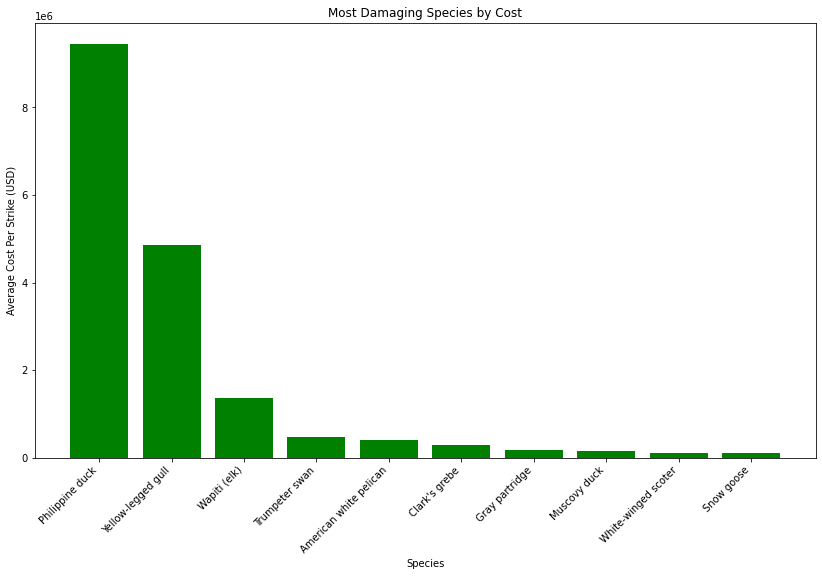

In [80]:
plt.figure(figsize=(14,8))

x_pos = [i for i in range(10)]

plt.bar(x_pos, strikes.Cost_per_Strike.values[0:10], color='green')
plt.xlabel("Species")
plt.ylabel("Average Cost Per Strike (USD)")
plt.title("Most Damaging Species by Cost")

plt.xticks(x_pos, strikes.SPECIES.values[0:10])

plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

This is suspicious. Philippine ducks are a threatened species native to the Philippines and they're not particularly large.

Indeed, if we look at the first entry, there is only one strike corresponding to this species.

In [81]:
strikes.iloc[0:1]

,SPECIES,COUNT,COST_REPAIRS,DAMAGE_M,DAMAGE_S,DAMAGE_D,Cost_per_Strike,Percent_DAMAGE_M,Percent_DAMAGE_S,Percent_DAMAGE_D
0,Philippine duck,1,9456000.0,0,1,0,9456000.0,0.0,100.0,0.0


To avoid weighting a single event too heavily, we will restrict our dataframe to species with at least 20 reported strikes. There are 333 of these.

In [82]:
strikes = strikes[strikes.COUNT >= 20]

In [83]:
len(strikes)

333

With these omissions, we plot the 20 species with the highest cost per strike.

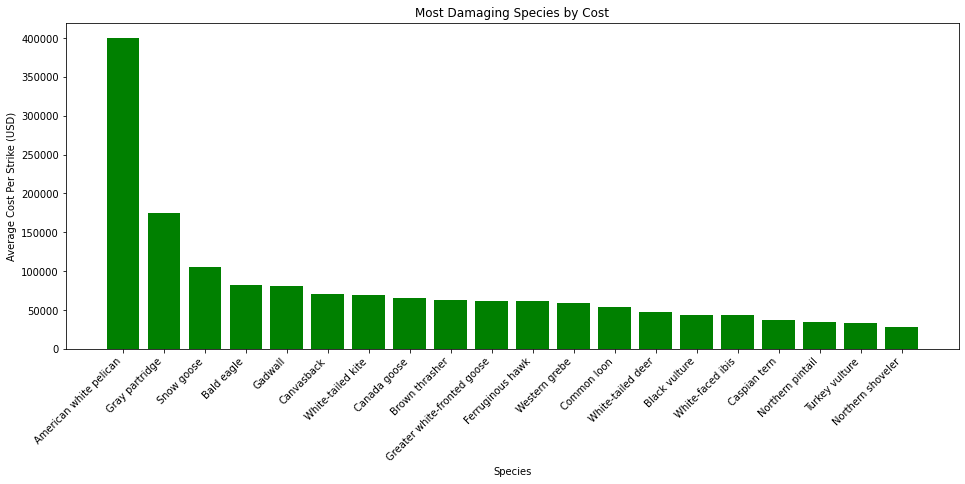

In [84]:
plt.figure(figsize=(16,6))

x_pos = [i for i in range(20)]

plt.bar(x_pos, strikes.Cost_per_Strike.values[0:20], color='green')
plt.xlabel("Species")
plt.ylabel("Average Cost Per Strike (USD)")
plt.title("Most Damaging Species by Cost")

plt.xticks(x_pos, strikes.SPECIES.values[0:20])
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

This is more believable as it includes mostly large birds native to the US.

To get a better idea of the shape of the tail of this data, we plot the 100 most damaging species by cost below without labels.

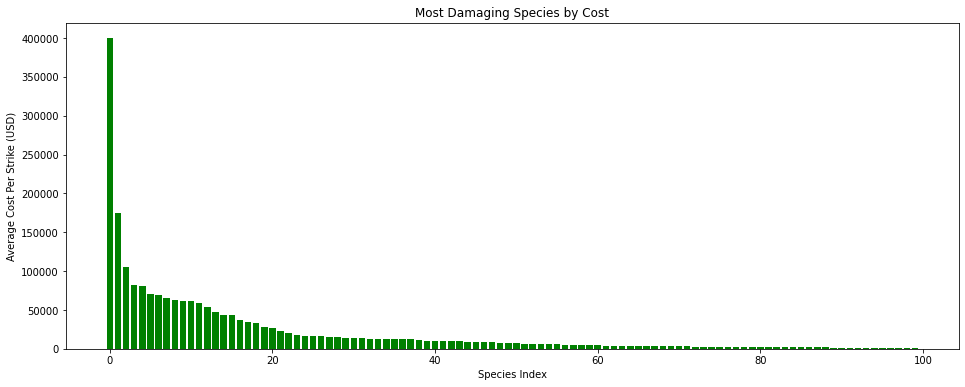

In [85]:
plt.figure(figsize=(16,6))

x_pos = [i for i in range(100)]

plt.bar(x_pos, strikes.Cost_per_Strike.values[0:100], color='green')
plt.xlabel("Species Index")
plt.ylabel("Average Cost Per Strike (USD)")
plt.title("Most Damaging Species by Cost")

plt.show()

59 species have costs per strike above \\$10,000 and 34 species have costs per strike above \\$25,000.

In [86]:
strikes[strikes.Cost_per_Strike >= 10000].index[-1]

58

In [87]:
strikes[strikes.Cost_per_Strike >= 25000].index[-1]

33

Now let's look at the most damaging species by damage classification.

In [88]:
strikes.sort_values(by='Percent_DAMAGE_D', ascending=False).head(10)

,SPECIES,COUNT,COST_REPAIRS,DAMAGE_M,DAMAGE_S,DAMAGE_D,Cost_per_Strike,Percent_DAMAGE_M,Percent_DAMAGE_S,Percent_DAMAGE_D
4,American white pelican,23,9196360.0,5,8,1,399842.0,21.74,34.78,4.35
66,Domestic dog,37,317600.0,2,6,1,8584.0,5.41,16.22,2.70
36,Mule deer,44,907327.0,10,19,1,20621.0,22.73,43.18,2.27
24,White-tailed deer,604,28957349.0,188,215,13,47943.0,31.13,35.60,2.15
135,Pied-billed grebe,49,62718.0,2,2,1,1280.0,4.08,4.08,2.04
25,Black vulture,260,11476535.0,39,46,5,44141.0,15.00,17.69,1.92
76,Pectoral sandpiper,53,329086.0,3,0,1,6209.0,5.66,0.00,1.89
33,Double-crested cormorant,171,4532175.0,9,21,2,26504.0,5.26,12.28,1.17
11,Bald eagle,283,23270595.0,42,24,3,82228.0,14.84,8.48,1.06
95,Swainson's hawk,197,675185.0,10,4,2,3427.0,5.08,2.03,1.02


Since the number of strikes in the DAMAGE_D column is so low and we would like to avoid weighting a single observation too heavily, we combine the DAMAGE_S and DAMAGE_D categories, restrict to species with at least 5 of these observations, and calculate the percentages for this new column.

In [89]:
strikes['DAMAGE_SD'] = strikes.DAMAGE_S + strikes.DAMAGE_D
strikes = strikes[strikes.DAMAGE_SD >= 5]
strikes['Percent_DAMAGE_SD'] = round(strikes.DAMAGE_SD*100 / strikes.COUNT, 2)

We now sort by this new column.

In [90]:
strikes = strikes.sort_values(by='Percent_DAMAGE_SD', ascending=False)

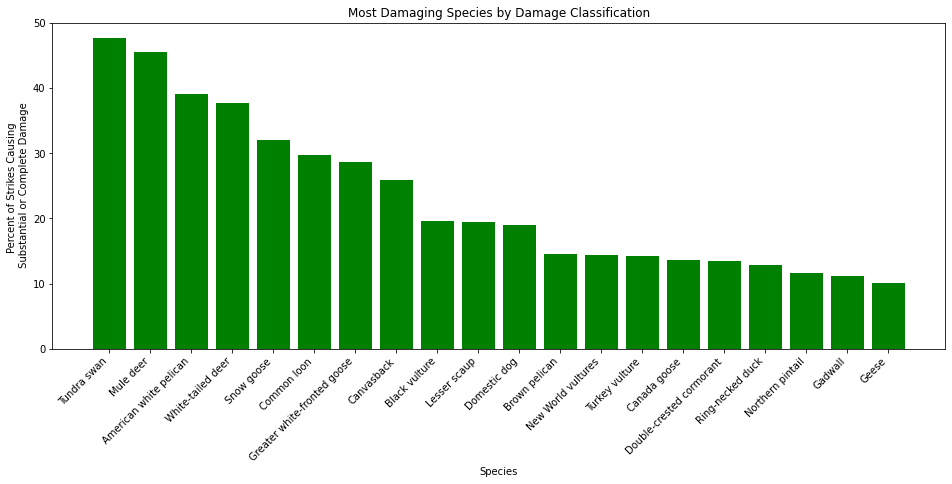

In [91]:
plt.figure(figsize=(16,6))

x_pos = [i for i in range(20)]

plt.bar(x_pos, strikes.Percent_DAMAGE_SD.values[0:20], color='green')
plt.xlabel("Species")
plt.ylabel("Percent of Strikes Causing \n Substantial or Complete Damage")
plt.title("Most Damaging Species by Damage Classification")

plt.xticks(x_pos, strikes.SPECIES.values[0:20])
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

The top species are similar to the cost data: mostly large birds. There are some differences. Runway animals like deer and dogs are ranked higher by this measure than by cost per flight. These differences are probably due to incomplete reporting and the more subjective nature of the damage classifications.

In [94]:
len(strikes)

62

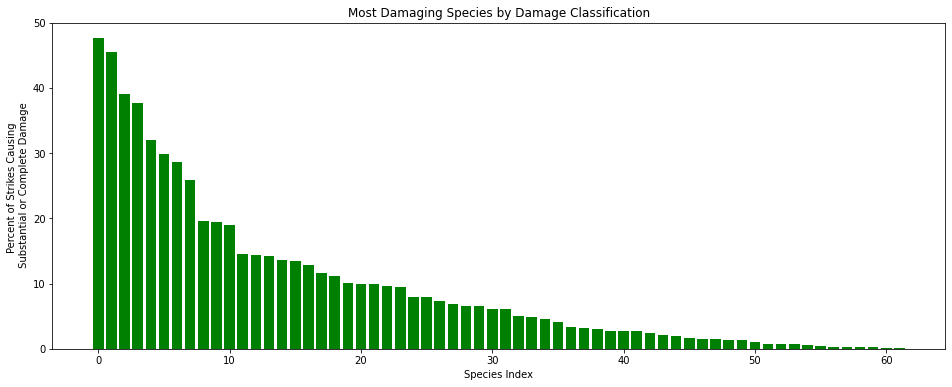

In [95]:
plt.figure(figsize=(16,6))

x_pos = [i for i in range(62)]

plt.bar(x_pos, strikes.Percent_DAMAGE_SD.values, color='green')
plt.xlabel("Species Index")
plt.ylabel("Percent of Strikes Causing \n Substantial or Complete Damage")
plt.title("Most Damaging Species by Damage Classification")

plt.show()